In [1]:
# Import the standard modules
import pathlib

# Import spiceypy
import spiceypy

# Load necessary SPICE kernels
spiceypy.furnsh('kernel_meta.txt')

# Import the installed modules
import numpy as np

# Import matplotlib for plotting
from matplotlib import pyplot as plt

In [2]:
# Create sample Ephemeris Time (ET)
SAMPLE_ET = spiceypy.utc2et('2000-001T00:00:00')

# Compute the state vector of Jupiter's barycentre at the defined ET as seen
# from the Sun
STATE_VEC_JUPITER, _ = spiceypy.spkgeo(targ=5, \
                                       et=SAMPLE_ET, \
                                       ref='ECLIPJ2000', \
                                       obs=10)

# Get the G*M value of the Sun
_, GM_SUN = spiceypy.bodvcd(bodyid=10, item='GM', maxn=1)
GM_SUN = GM_SUN[0]

# Compute the orbital elements of Jupiter ...
ORB_ELEM_JUPITER = spiceypy.oscltx(STATE_VEC_JUPITER, SAMPLE_ET, GM_SUN)

# ... extract the semi-major axis and convert it from km to AU
A_JUPITER_KM = ORB_ELEM_JUPITER[-2]
A_JUPITER_AU = spiceypy.convrt(A_JUPITER_KM, 'km', 'AU')

In [3]:
# Set the inclination range (however, only from 0 to 90 degrees) and convert
# the degrees values to radians
INCL_RANGE_DEG = np.linspace(0, 90, 100)
INCL_RANGE_RAD = np.radians(INCL_RANGE_DEG)

# Set an array for the eccentricity
E_RANGE = np.linspace(0, 1, 100)

# Tisserand parameter w.r.t. to Jupiter as a lambda function (a is the
# semi-major axis, i is the inclination and e is the eccentricty of the
# object)
tisserand_jup = lambda a, i, e: (A_JUPITER_AU / a) \
                                + 2 * np.cos(i) \
                                * np.sqrt((a / A_JUPITER_AU) * (1 - (e**2.0)))

# Create a mesh grid for the 2 D colour contour plot
E_MESH, INCL_RAD_MESH = np.meshgrid(E_RANGE, INCL_RANGE_RAD)

In [4]:
# Import the matplotlib colormap
from matplotlib import cm

# Let's set a dark background
plt.style.use('dark_background')

# Set a default font size for better readability
plt.rcParams.update({'font.size': 14})

# Set an array for the semi-major axis (for each semi-major axis an individual
# contour plot will be created). Let's set a step-size of 0.1 AU
DELTA_A = 0.1
A_ARRAY = np.arange(1.0, 8.0 + DELTA_A, DELTA_A)

100%|██████████| 71/71 [00:20<00:00,  3.50it/s]


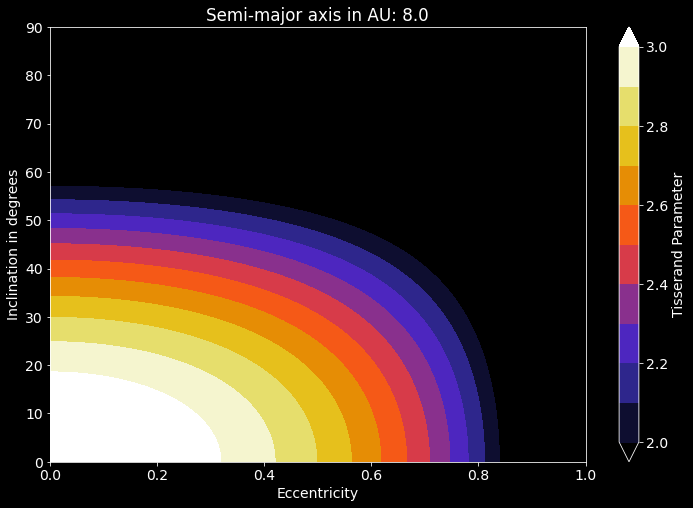

In [5]:
# Create a temporary folder to store all figures
pathlib.Path('temp/').mkdir(parents=True, exist_ok=True)

# Import tqdm for a proper progress visualisation
from tqdm import tqdm

# Set a figure size
fig, _ = plt.subplots(figsize=(12, 8))

# Iterate through the semi-major axis array, create and save the resulting
# contour plots
for a_for in tqdm(range(len(A_ARRAY))):

    # Clear the plot for each re-draw
    plt.clf()

    # Set the x and y axis limits (eccentricity and inclination)
    plt.xlim(0, 1)
    plt.ylim(0, 90)

    # Compute the Tisserand parameter
    tiss_jup_mesh = tisserand_jup(A_ARRAY[a_for], INCL_RAD_MESH, E_MESH)

    # Display relevant information
    plt.title(f'Semi-major axis in AU: {round(A_ARRAY[a_for], 2)}')
    plt.xlabel('Eccentricity')
    plt.ylabel('Inclination in degrees')

    # Create a contour plot
    contr_plt = plt.contourf(E_MESH, np.degrees(INCL_RAD_MESH), \
                             tiss_jup_mesh, vmin=2, vmax=3, cmap=cm.CMRmap, \
                             extend='both', levels=np.linspace(2, 3, 11))

    # Add a colorbar that is also used in the following
    colbar = fig.colorbar(contr_plt)
    colbar.ax.set_ylabel('Tisserand Parameter')

    # Save the figure. Note: 100 DPI have been chosen, since the GIF that
    # shall be created in a moment cannot exceed 25 MB for the Medium article
    plt.savefig('temp/'+str(a_for+1).zfill(3)+'.png', dpi=100)

In [6]:
# In this part all figures are merged into one animation (GIF)

# Import glob to get the paths to all figures in the temporary folder
import glob
FILE_NAMES = glob.glob('temp/*.png')

# Our animation should be though-out. Let's create a GIF that starts with
# a = 1, goes up to the last image ... waits for short period of time and then
# reverses back to a = 1. The result: A nice repeating "back and forth"
# animation without any image "glitches" or "jumps"

# Create a list that goes from a = 1 to a = 8 AU
file_name_list = sorted(FILE_NAMES)

# Extend the list with 25 images of the last entry (a = 8 AU)
file_name_list.extend([file_name_list[-1]] * round(25))

# "Go back in time" by extending the array with a reversed copy (a = 8 AU to
# a = 1 AU)
file_name_list.extend(sorted(FILE_NAMES)[::-1])

# Add again the initial frame (a = 1 AU) for a second break
file_name_list.extend([file_name_list[-1]] * round(25))

In [7]:
# Import imageio. This library supports us to create an animation
import imageio

# Set an empty list that will contain all images
tisserand_images = []

# Iterate through the list of image paths, read the image with the imageio
# library and append the result to the list
for figure_f in file_name_list:
    tisserand_images.append(imageio.imread(figure_f))

# Save the list of images as a GIF. The duration of a single image is given
# in seconds
imageio.mimsave('tisserand_animated_vis.gif', tisserand_images, duration=0.04)